# Aufgabe 4

## Loading Data

In [1]:
import pandas as pd
import numpy as np
import itertools
import mdptoolbox
import matplotlib.pyplot as plt

training_data = pd.read_csv('Exercise 4 - Reinforcement Learning Data - warehousetraining.txt', delimiter='\t', header=None, names=["action", "color"])
test_data = pd.read_csv('Exercise 4 - Reinforcement Learning Data - warehouseorder.txt', delimiter='\t', header=None, names=["action", "color"])

In [2]:
#calculate probability from training set
move_probs = (training_data.color.value_counts() / training_data.shape[0])
move_probs

red      0.493723
white    0.255699
blue     0.250578
Name: color, dtype: float64

# 2x2 Warehouse

In [3]:
# #items
item_positions = [0, 1, 2, 3]

# costs to reach items (Manhattan Distance)
travel_costs = [1, 2, 2, 3]

# reward when storing items (negativ Manhattan Distance)
reward_distribution = [-1, -2, -2, -3]

In [4]:
def gen_action_states(actionless_state, actions):
    tmp_action_states = []
    for action in actions:
        tmp_action_state = []
        for state in actionless_state:
            tmp_action_state.append(state)
        tmp_action_state.append(action)
        tmp_action_states.append(tuple(tmp_action_state))
    return tmp_action_states

def gen_states():
    storage_state = ["0","r","b","w"] # 0 = empty, r = red, b = blue, w = white
    actionless_states = [i for i in itertools.product(storage_state, repeat=len(item_positions))]
    action_states = []
    actions = ["sr", "sb", "sw", "rr", "rb", "rw"] # s_ = store, r_ = read
    for state_without_action in actionless_states:
        action_states.extend(gen_action_states(state_without_action, actions))
    return action_states

## Generate state and probability matrix

In [5]:
def get_color(state):
    return state[len(item_positions)][1].lower()

def is_full(state):
    return "0" not in state

def is_empty(state):
    for s in state:
        if s != '0':
            return False
    return True

def distribute_transition_prob_matrix(transition_prob_matrix):
    for index, row_vector in enumerate(transition_prob_matrix):
        sum = np.sum(row_vector)
        if sum == 0:
            transition_prob_matrix[index, index] = 1
            continue
    transition_prob_matrix = transition_prob_matrix / transition_prob_matrix.sum(axis=1)[:, None]
    return transition_prob_matrix

def is_transition_possible(pos, state_1, state_2):
    curr_action = state_1[len(item_positions)]
    if curr_action[0] == 's':
        if is_full(state_1): return False
        color_to_store = get_color(state_1)
        for i in range(len(state_1)):
            if i == len(item_positions):
                break
            if i == pos:
                continue
            if state_1[i] != state_2[i]:
                return False
        if state_1[pos] == "0" and state_2[pos] != color_to_store and state_2[pos] != "0":
            return False
        if state_1[pos] == "0" and state_2[pos] == color_to_store:
            return True   
        return False
    else:
        color_to_restore = get_color(state_1)
        if color_to_restore not in state_1 or is_empty(state_1):
            # can't restore
            return False
        for i in range(len(state_1)):
            if i == len(item_positions):
                break 
            if i == pos:
                continue
            if state_1[i] != state_2[i]:
                return False  
        if state_1[pos] == "0":
            return False
        if state_1[pos] == color_to_restore and state_2[pos] != "0" and state_2[pos] != color_to_restore:
            return False
        if state_1[pos] == color_to_restore and state_2[pos] == '0':
            return True
        return False

def get_transition_prob_matrix(states):
    matrix = np.zeros((len(states), len(states)), order='C')
    for x, curr_state in enumerate(states):
        for y, next_state in enumerate(states):
            if is_transition_possible(curr_state, next_state):
                matrix[x, y] = 1
    return distribute_transition_prob_matrix(matrix)

def create_prob_matrix(states, distributions):
    tpm_res = []
    for i, pos in enumerate(item_positions):
        tpm = np.zeros((len(states), len(states)),dtype=np.float16)
        print("Generate", i + 1)
        store_data = distribution_data['action'] == 'store'
        restore_data = distribution_data['action'] == 'restore'
        for x, curr_state in enumerate(states):
            for y, next_state in enumerate(states):
                if is_transition_possible(pos, curr_state, next_state):
                    state_col = next_state[len(item_positions)].lower()
                    if state_col == 'sr':
                        tpm[x, y] = distribution_data.loc[store_data & (distribution_data['color'] == 'red'), 'count'].item()
                    elif state_col == 'sw':
                        tpm[x, y] = distribution_data.loc[store_data & (distribution_data['color'] == 'white'), 'count'].item()
                    elif state_col == 'sb':
                        tpm[x, y] = distribution_data.loc[store_data & (distribution_data['color'] == 'blue'), 'count'].item()
                    elif state_col == 'rr':
                        tpm[x, y] = distribution_data.loc[restore_data & (distribution_data['color'] == 'red'), 'count'].item()
                    elif state_col == 'rw':
                        tpm[x, y] = distribution_data.loc[restore_data & (distribution_data['color'] == 'white'), 'count'].item()
                    else:
                        tpm[x, y] = distribution_data.loc[restore_data & (distribution_data['color'] == 'blue'), 'count'].item()
                  
        distributed_tpm = distribute_transition_prob_matrix(tpm)
        tpm_res.append(distributed_tpm)    
    return tpm_res

In [6]:
def get_store_reward(state, pos, reward_distribution):
    if state[pos] != '0':
        return -10
    else:
        col = get_color(state)
        f = 1
        store_data = distribution_data['action'] == 'store'
        if col == 'r':
            f *= distribution_data.loc[store_data & (distribution_data['color'] == 'red'), 'count'].item()
        if col == 'w':
            f *= distribution_data.loc[store_data & (distribution_data['color'] == 'white'), 'count'].item()
        if col == 'b':
            f *= distribution_data.loc[store_data & (distribution_data['color'] == 'blue'), 'count'].item()
        return reward_distribution[pos] * f
        
def get_restore_reward(state, pos, reward_distribution):
    if state[pos] != get_color(state):
        # no able to restore
        return -100
    else:
        return reward_distribution[pos]
    
def gen_reward_matrix(states, item_positions, reward_distribution):
    rm = np.zeros((len(states), len(item_positions)))
    for pos in item_positions:
        for j, state in enumerate(states):
            if state[len(item_positions)][0] == 's':
                rm[j, pos] = get_store_reward(state, pos, reward_distribution)
            elif state[len(item_positions)][0] == 'r':
                rm[j, pos] = get_restore_reward(state, pos, reward_distribution)
            else:
                return False
    return rm
    
def get_new_warehouse(warehouse, pos, action, color):
    col_symbol = color[0]
    if action == 'store' and warehouse[pos] == '0':
        warehouse[pos] = col_symbol
    elif action == 'restore' and warehouse[pos] != '0':
        warehouse[pos] = '0'
    return warehouse


states = gen_states()

distribution_data = training_data.copy()
distribution_data = distribution_data.groupby(['action', 'color']).size().reset_index(name='count')
distribution_data['count'] = distribution_data['count'].div(len(training_data))

prob_matrix = create_prob_matrix(states, distribution_data)

Generate 1
Generate 2
Generate 3
Generate 4


# Generate reward matrix

In [7]:
reward_matrix = gen_reward_matrix(states, item_positions, reward_distribution)
#plt.plot(reward_matrix)
#plt.show()

# Test with different reinforcement algorithm

In [8]:
def get_first_item(warehouse, color, travel_costs):
    col_symbol = color[0]
    for index, pos in enumerate(warehouse):
        if pos == col_symbol:
            warehouse[index] = '0'
            result = [travel_costs[index]*2, warehouse]
            return result
    return False

def get_state(warehouse, action, color):
    action = action[0] + color[0]
    if len(warehouse) == len(item_positions):
        warehouse.append(action)
    elif len(warehouse) == len(item_positions)+1:
        warehouse[len(item_positions)] = action
    return warehouse

def get_state_nr(warehouse):
    for index, state in enumerate(states):
        if state == tuple(warehouse):
            return index
    return ''

def store_in_next_empty(warehouse, color, travel_costs):
    col_symbol = color[0]
    for index, pos in enumerate(warehouse):
        if pos == '0':
            warehouse[index] = col_symbol
            result = [travel_costs[index]*2, warehouse]
            return result
    return False

def test_algorithm(policy: tuple):
    warehouse = ["0"] * len(item_positions)

    field_to_go = 0
    warehouse_states = []
    for index, row in test_data.iterrows():
        action_warehouse = get_state(warehouse, row.action, row.color)
        state = get_state_nr(action_warehouse)
        
        if state != '':
            warehouse_position = policy[state]
            field_to_go += travel_costs[warehouse_position] * 2
            warehouse = get_new_warehouse(warehouse, warehouse_position, row.action, row.color)
            warehouse_tuple = tuple(warehouse)
            warehouse_states.append(warehouse_tuple)
        else:
            print(action_warehouse, state)
            return 'failed'
    result = [field_to_go, warehouse_states]
    return result

def greedy_dist(costs):
    warehouse = ["0"]*len(item_positions)
    distance_traveled = 0
    warehouse_states = []
    for index, row in test_data.iterrows():
        warehouse_state = ""
        if row.action == 'store':
            warehouse_state = store_in_next_empty(warehouse, row.color, costs)
            if warehouse_state:
                warehouse_tuple_store = tuple(warehouse_state[1])
                warehouse_states.append(warehouse_tuple_store)
                distance_traveled += warehouse_state[0]
        elif row.action == 'restore':
            warehouse_state = get_first_item(warehouse, row.color, costs)
            if warehouse_state:
                warehouse_tuple_restore = tuple(warehouse_state[1])
                warehouse_states.append(warehouse_tuple_restore)
                distance_traveled += warehouse_state[0]        
    result = [distance_traveled, warehouse_states]
    return result


discount = 0.95
max_iter = len(states) * 2

mdps = []
mdps.append(('PolicyIteration:', mdptoolbox.mdp.PolicyIteration(prob_matrix, reward_matrix, 0.2, max_iter=max_iter)))
mdps.append(('PolicyModifiedIteration:', mdptoolbox.mdp.PolicyIterationModified(prob_matrix, reward_matrix, discount, max_iter=max_iter)))
mdps.append(('RelativeValueIteration:', mdptoolbox.mdp.RelativeValueIteration(prob_matrix, reward_matrix, discount, max_iter=max_iter)))
mdps.append(('ValueIteration:', mdptoolbox.mdp.ValueIteration(prob_matrix, reward_matrix, discount, max_iter=max_iter)))
mdps.append(('ValueIterationGS:', mdptoolbox.mdp.ValueIterationGS(prob_matrix, reward_matrix, discount, max_iter=max_iter)))

print("Traveling Distance: \n")

for mdp in mdps:
    mdp[1].run()
    print(mdp[0], test_algorithm(mdp[1].policy)[0])
    
print("Greedy:", greedy_dist(travel_costs)[0])

Traveling Distance: 

PolicyIteration: 200
PolicyModifiedIteration: 120
RelativeValueIteration: 120
ValueIteration: 120
ValueIterationGS: 120
Greedy: 168


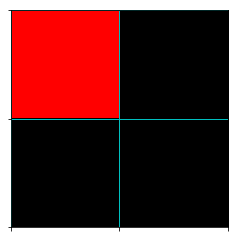

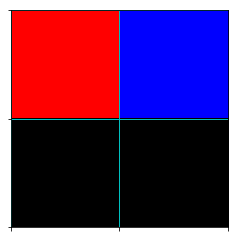

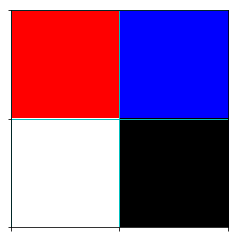

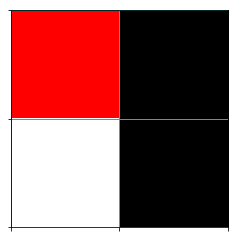

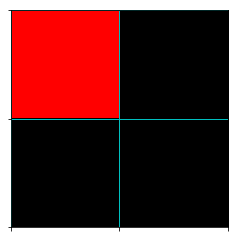

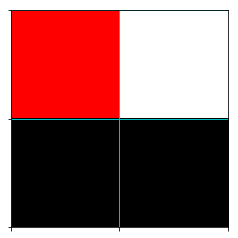

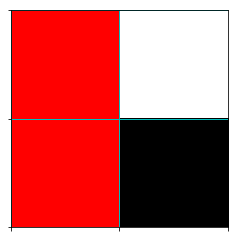

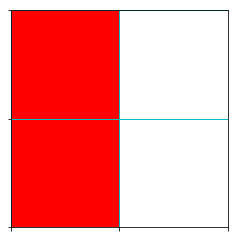

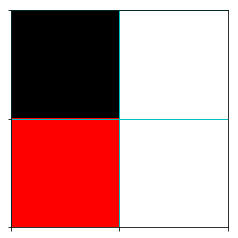

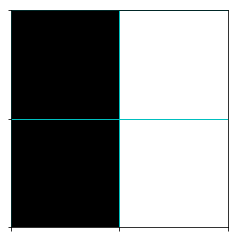

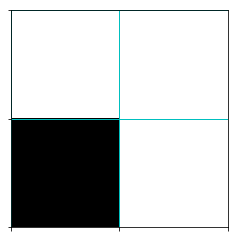

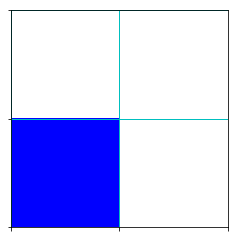

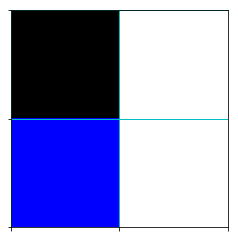

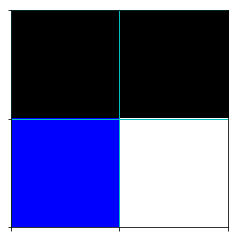

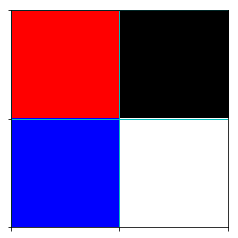

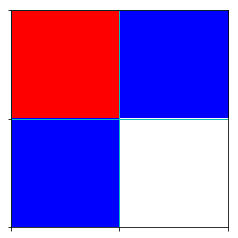

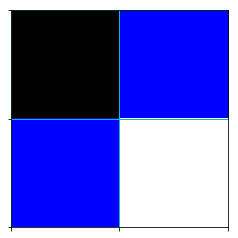

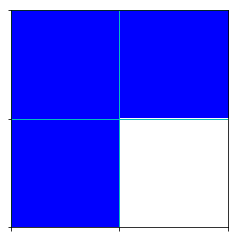

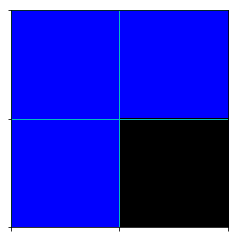

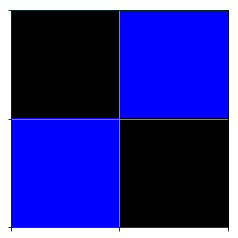

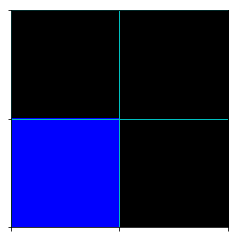

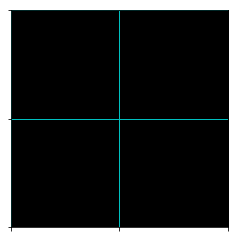

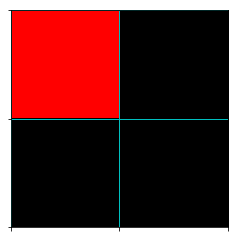

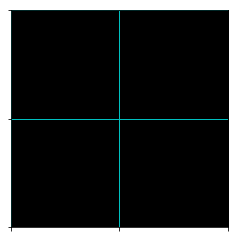

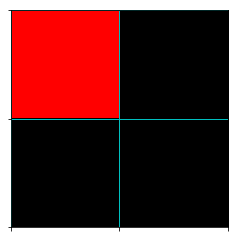

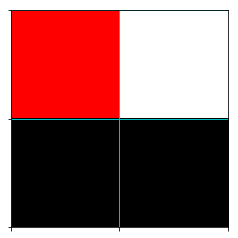

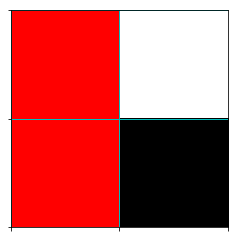

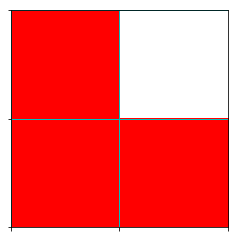

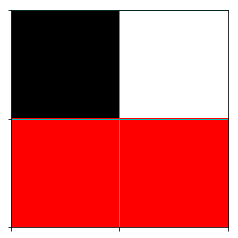

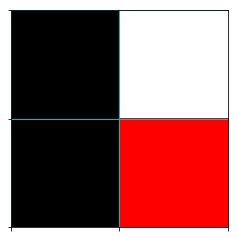

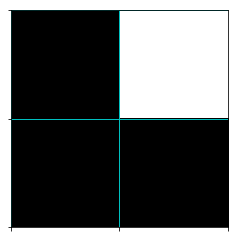

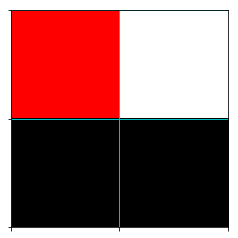

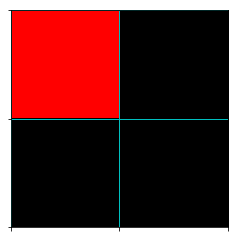

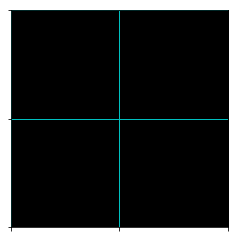

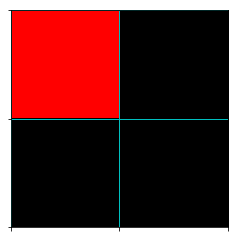

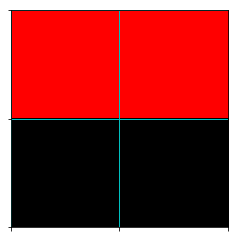

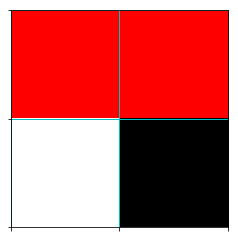

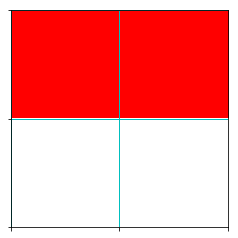

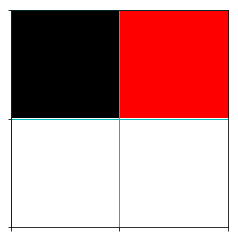

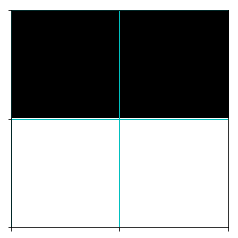

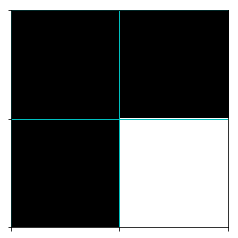

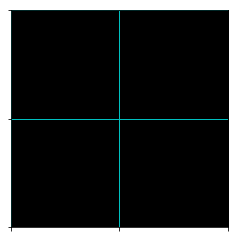

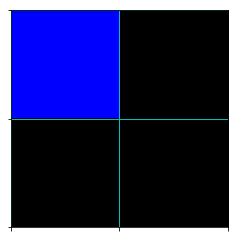

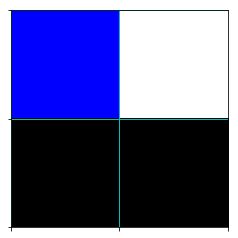

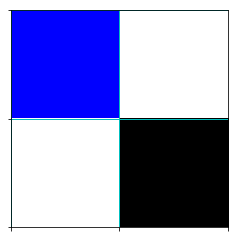

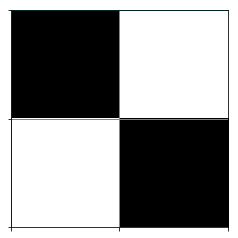

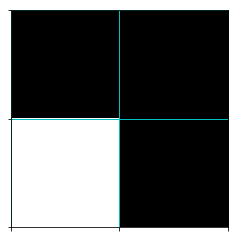

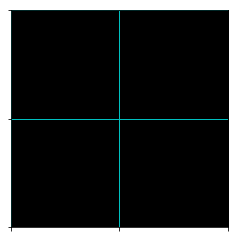

In [9]:
def color_to_rgb(color):
    if color == "r":
        return (255, 0, 0)
    elif color == "b":
        return (0, 0, 255)
    elif color == "w":
        return (255, 255, 255)
    return (0, 0, 0)

for state in greedy_dist(travel_costs)[1]:
    ax = plt.gca()
    ax.set_xticks(np.arange(-.5, 2, 1))
    ax.set_yticks(np.arange(-.5, 2, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.grid(color='c', linewidth=1)

    im = np.array([color_to_rgb(color) for color in state]).reshape(2, 2, 3)
    plt.imshow(im)
    plt.show()